In [19]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import data_util

In [20]:
# apple_stocks=data_util.stock_data('AAPL',4,'Apple')
n_stocks=data_util.stock_data('^NSEI', 4,'Nifty 50')
# plot(apple_stocks,'Apple')  

[*********************100%%**********************]  1 of 1 completed


In [21]:
stocks = n_stocks[['Close']].copy()

### We First do the Augmented Dickey Fuller Test to check the Stationarity of the Data


In [22]:
test_Results=adfuller(stocks["Close"])
print("p-value of the Test",test_Results[1])

p-value of the Test 0.2712753932154557


#### Since the p-value is large , we conclude that the data is not stationary. We take the difference and again do the ADS test .

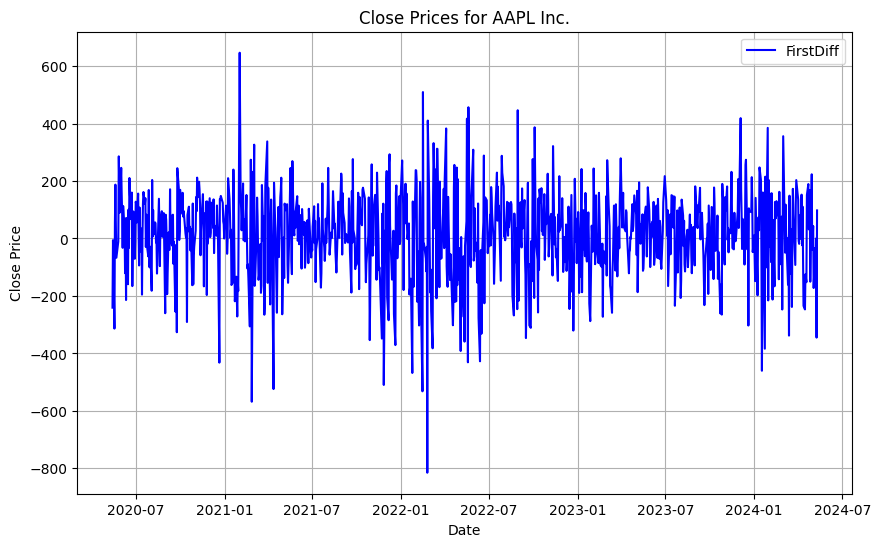

In [23]:
stocks['FirstDiff'] = stocks['Close'].diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(stocks.index, stocks['FirstDiff'], color='blue', label='FirstDiff')
plt.title(f'Close Prices for {"AAPL"} Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()  
plt.grid(True)
plt.show()

In [24]:
test_Results=adfuller(stocks["FirstDiff"][1:])#first entry will be Nan
print("p-value of the Test",test_Results[1])

p-value of the Test 2.770909143632516e-28


#### On taking the first difference we get the p-value as low as 0.00 , thus we conclude the first diffeernce data is stationary . This can be further be confirmed by using ndiff function in pmdarima library.

In [25]:
from pmdarima.arima.utils import ndiffs

d = ndiffs(stocks["Close"])

print("No. of differences needed:", d)

No. of differences needed: 1


#### Now we plot AutoCorrelation Function(ACF) and Partial AutoCorrelation Function(PACF) to determing the order of ARIMA model.

<BarContainer object of 29 artists>

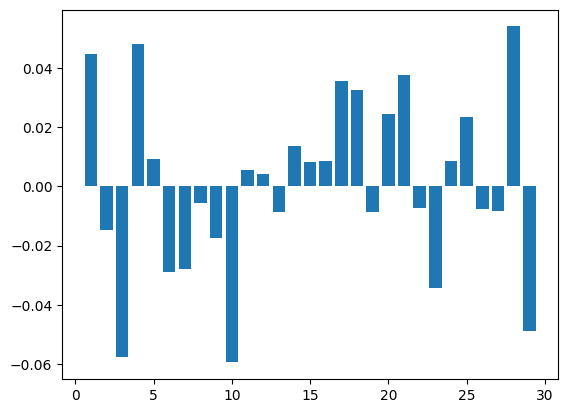

In [26]:
acf_vals = acf(stocks['FirstDiff'][1:])
plt.bar(range(1,acf_vals.shape[0]), acf_vals[1:acf_vals.shape[0]])
# acf_vals.shape

<BarContainer object of 29 artists>

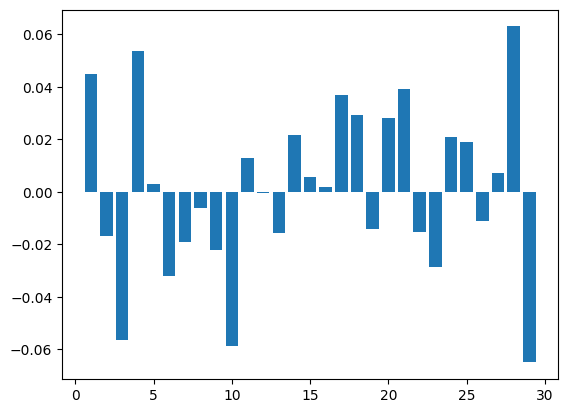

In [27]:
pacf_vals = pacf(stocks['FirstDiff'][1:])
plt.bar(range(1,pacf_vals.shape[0]), pacf_vals[1:pacf_vals.shape[0]])

In [28]:
train=pd.DataFrame(stocks['Close'][0:int(len(stocks)*0.70)])
test=pd.DataFrame(stocks['Close'][int(len(stocks)*0.70):])


In [29]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(train, order=(4,1,4))
# model = ARIMA(stocks['FirstDiff'][1:], order=(2,0,2))

model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  693
Model:                 ARIMA(4, 1, 4)   Log Likelihood               -4474.400
Date:                Mon, 13 May 2024   AIC                           8966.800
Time:                        05:06:04   BIC                           9007.656
Sample:                             0   HQIC                          8982.602
                                - 693                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9176      0.169      5.421      0.000       0.586       1.249
ar.L2         -0.9155      0.120     -7.639      0.000      -1.150      -0.681
ar.L3          0.9100      0.115      7.915      0.0

(array([9.99112129e-06, 9.99112129e-06, 6.99378490e-05, 3.19715881e-04,
        1.11900558e-03, 2.55772705e-03, 2.14809108e-03, 5.79485035e-04,
        7.99289703e-05, 1.99822426e-05]),
 array([-818.80496063, -674.16787106, -529.53078149, -384.89369191,
        -240.25660234,  -95.61951277,   49.0175768 ,  193.65466637,
         338.29175594,  482.92884552,  627.56593509]),
 <BarContainer object of 10 artists>)

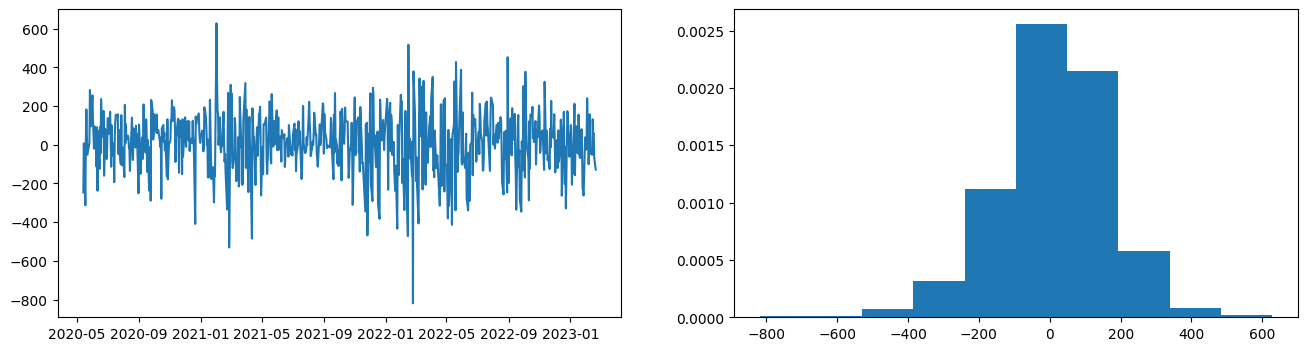

In [30]:
residuals = pd.DataFrame(model_fit.resid[1:])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)

ax2.hist(residuals, density=True)

In [31]:
predictions = model_fit.forecast(len(test))

dates = test.index.tolist()  # Convert index to list of dates
predictions = predictions.tolist()  # Convert predicted values to list

# Create a DataFrame using the lists of dates and predictions
predicted_df = pd.DataFrame({'Predicted_Value': predictions}, index=dates)

# Print the DataFrame
print(predicted_df)



            Predicted_Value
2023-02-21     17838.202360
2023-02-22     17820.590644
2023-02-23     17851.323509
2023-02-24     17859.126824
2023-02-27     17826.523550
...                     ...
2024-05-06     17834.536868
2024-05-07     17834.536846
2024-05-08     17834.536851
2024-05-09     17834.536868
2024-05-10     17834.536855

[297 rows x 1 columns]


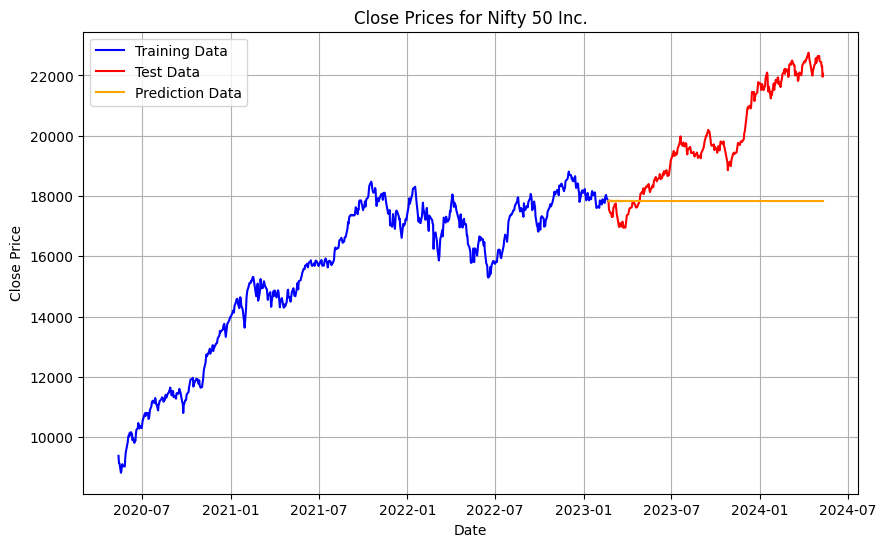

In [32]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(predicted_df.index, predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for Nifty 50 Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


## Rolling Forecast Origin

In [53]:
import warnings
warnings.filterwarnings("ignore")
rolling=int(len(stocks)*0.70)
train=pd.DataFrame(stocks['Close'][0:rolling])
test=pd.DataFrame(stocks['Close'][rolling:])
predictions_rolling=[]
for i in range(len(test)):
    try:
        model = ARIMA(train, order=(4,1,4))
        model_fit = model.fit()
        pred=model_fit.forecast()
        predictions_rolling.append(pred)
        print(float(pred),test['Close'][i])
    except:
        predictions_rolling.append(stocks['Close'][rolling])
        print("Singular Matrix found")
    rolling+=1
    train=pd.DataFrame(stocks['Close'][0:rolling])
print(predictions_rolling)

17838.202359596045 17826.69921875
17805.718092600466 17554.30078125
17585.84730418525 17511.25
17535.784437428767 17465.80078125
17449.232901863885 17392.69921875
17371.355960545265 17303.94921875
17288.07694566623 17450.900390625
17419.879425480965 17321.900390625
17299.212187856145 17594.349609375
17595.89233132711 17711.44921875
17735.14699976342 17754.400390625
17748.284312860145 17589.599609375
17587.702236763645 17412.900390625
17455.810778294377 17154.30078125
17146.11822195171 17043.30078125
17027.393073587704 16972.150390625
16985.545590321366 16985.599609375
16993.670601170536 17100.05078125
17090.318567360187 16988.400390625
16983.044658648014 17107.5
17122.66708614471 17151.900390625
17156.914547053268 17076.900390625
17057.408216789678 16945.05078125
16939.22857373296 16985.69921875
17003.15682404963 16951.69921875
16945.630641424996 17080.69921875
17071.693258376694 17359.75
17395.043730925954 17398.05078125
17400.932711342735 17557.05078125
17535.53076580146 17599.150390

In [54]:
predictions

[17838.202359596045,
 17820.590644265187,
 17851.32350924425,
 17859.12682387716,
 17826.52355040443,
 17829.533114063477,
 17848.119072033143,
 17827.38780481448,
 17816.49733020286,
 17840.326627768354,
 17840.523493967645,
 17823.22855268297,
 17836.347082451084,
 17848.018400096047,
 17830.845714101386,
 17828.227630278307,
 17843.149888237254,
 17835.591199150716,
 17824.415324788308,
 17836.45793036728,
 17840.60501898598,
 17828.41161856466,
 17832.065933662245,
 17842.078283368508,
 17833.97453772978,
 17829.078558572604,
 17838.603699778192,
 17837.570432402652,
 17829.017157143975,
 17834.14703322357,
 17839.197408640648,
 17832.062594148112,
 17831.438974491823,
 17838.468115815096,
 17835.525459782544,
 17830.726778157117,
 17835.842157003324,
 17837.420140405484,
 17831.841157072686,
 17833.230224709085,
 17837.53217823745,
 17834.046867843805,
 17832.008972711865,
 17836.28948538732,
 17835.954655448746,
 17832.269904373123,
 17834.491012358718,
 17836.655608810568,
 1783

In [55]:
predictions_rolling=[float(i) for i in predictions_rolling]

In [58]:

dates = test.index.tolist()

rolling_predicted_df = pd.DataFrame({'Predicted_Value': predictions_rolling}, index=dates)

# Print the DataFrame
print(rolling_predicted_df)


            Predicted_Value
2023-02-21     17838.202360
2023-02-22     17805.718093
2023-02-23     17585.847304
2023-02-24     17535.784437
2023-02-27     17449.232902
...                     ...
2024-05-06     22448.934208
2024-05-07     22453.231351
2024-05-08     22339.084955
2024-05-09     22286.532371
2024-05-10     21945.374282

[297 rows x 1 columns]


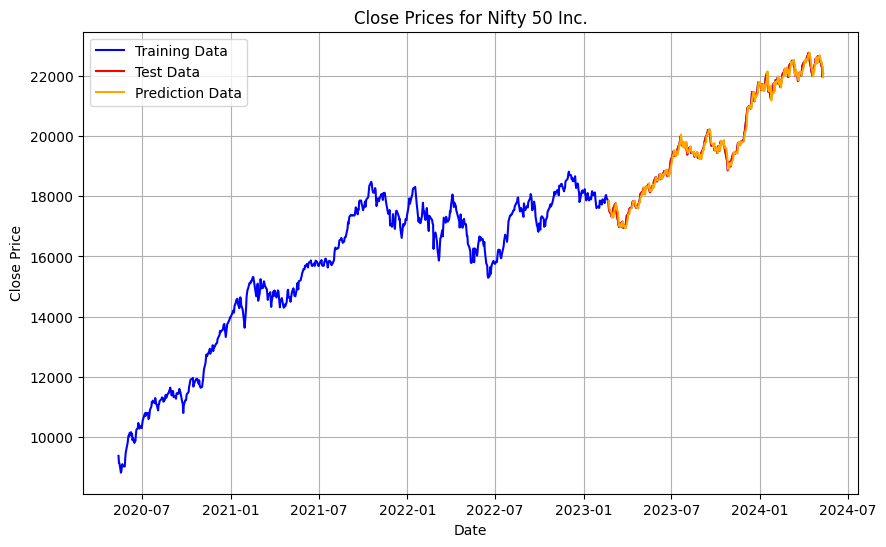

In [59]:
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(train.index, train, color='blue', label='Training Data')

# Plot test data
plt.plot(test.index, test, color='red', label='Test Data')
plt.plot(rolling_predicted_df.index, rolling_predicted_df, color='orange', label='Prediction Data')

plt.title('Close Prices for Nifty 50 Inc.')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

In [61]:
y_true=test["Close"].values
y_pred=rolling_predicted_df["Predicted_Value"].values
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

,Metric,Value
0,MAPE,0.52
1,MAE,104.27
2,MSE,17956.22
3,RMSE,134.00
4,R2,0.99
5,SMAPE,0.52
